In [417]:
import pandas as pd

In [40]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'final_data_finale4.csv'
data = pd.read_csv(file_path)

# Function to find the closest temperature and return the corresponding Cp value
def find_closest_cp(temp, cp_table):
    cp_table['Temp_diff'] = abs(cp_table['T'] - temp)
    closest_row = cp_table.loc[cp_table['Temp_diff'].idxmin()]
    return closest_row['Cp']

# Create Cp tables for Y2O3 and ZrO2
cp_y2o3 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1330, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [102.5, 102.8, 113.0, 118.1, 121.1, 123.2, 124.7, 125.9, 127.0, 127.9, 128.8, 129.6, 129.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 137.6, 152.4, 151.8, 160.1, 161.1]
})

cp_zro2 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1478, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [56.1, 56.3, 63.8, 67.6, 70.2, 72.0, 73.5, 74.7, 75.7, 76.6, 77.7, 78.6, 79.5, 80.8, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 87.9, 80.8, 78.6, 75.1, 74.5]
})


temp_column = 'Mean Particle Temperature (°C)'  # Assuming this is the column for temperature
x = 0.8  # Proportion for Y2O3

# Add the new Cp column to the dataset
data['Cp'] = data[temp_column].apply(lambda temp: (1 - x) * find_closest_cp(temp, cp_zro2) + x * find_closest_cp(temp, cp_y2o3))

data.head()


,Ar (SLM),N2 (SLM),H2 (SLM),Mean Particle Temperature (°C),Mean Particle Velocity (m/s),enthalpy,BP(°C),PS,MP,SPC,Cp
0,128.0,56.0,16.0,2447.5,387.2,9.7,100.0,3.34,2700,0.625,120.34
1,98.0,86.0,16.0,2506.8,379.9,12.0,100.0,3.34,2700,0.625,120.34
2,108.0,56.0,36.0,2546.0,383.2,9.8,100.0,3.34,2700,0.625,120.34
3,78.0,86.0,36.0,2517.6,379.8,7.8,100.0,3.34,2700,0.625,120.34
4,118.0,26.0,56.0,2481.8,340.1,6.9,100.0,3.34,2700,0.625,120.34


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Separate the conditions (BP, PS, MP, SPC) and the features (Ar_un, N2_un, H2_un)
conditions = data[['BP(°C)', 'PS', 'Mean Particle Temperature (°C)','Cp']].values
features = data[['Ar (SLM)', 'N2 (SLM)', 'H2 (SLM)']].values

In [42]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
features_train, features_test, conditions_train, conditions_test = train_test_split(
    features, conditions, test_size=0.2, random_state=42
)

# Standardize the data
scaler_features = MinMaxScaler()
scaler_conditions = MinMaxScaler()

features_train_scaled = scaler_features.fit_transform(features_train)
features_test_scaled = scaler_features.transform(features_test)
conditions_train_scaled = scaler_conditions.fit_transform(conditions_train)
conditions_test_scaled = scaler_conditions.transform(conditions_test)

# Convert data to PyTorch tensors
features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)
features_test_tensor = torch.tensor(features_test_scaled, dtype=torch.float32)
conditions_train_tensor = torch.tensor(conditions_train_scaled, dtype=torch.float32)
conditions_test_tensor = torch.tensor(conditions_test_scaled, dtype=torch.float32)

# Create DataLoader for training data
train_dataset = TensorDataset(features_train_tensor, conditions_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Create DataLoader for testing data
test_dataset = TensorDataset(features_test_tensor, conditions_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [43]:
data.columns

Index(['Ar (SLM)', 'N2 (SLM)', 'H2 (SLM)', 'Mean Particle Temperature (°C)',
       'Mean Particle Velocity (m/s)', 'enthalpy', 'BP(°C)', 'PS', 'MP', 'SPC',
       'Cp'],
      dtype='object')

In [44]:
import torch.nn as nn
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, 512)
        self.fc2 = nn.Linear(512, 216)
        self.fc3 = nn.Linear(216, 120)
        self.fc4 = nn.Linear(120, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x, c):
        x = torch.cat([x, c], dim=1)  # Concatenate input data and conditions
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, cond_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, z, c):
        z = torch.cat([z, c], dim=1)  # Concatenate latent variables and conditions
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        z = self.fc3(z)
        return z

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPP_CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super(GPP_CVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, cond_dim)
        self.decoder = Decoder(latent_dim, input_dim, cond_dim)
        self.likelihood = GaussianLikelihood()
        self.gp_model = None
        self.train_x = None
        self.train_y = None
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, c)
        return recon_x, mu, logvar, z

    def set_gp_model(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        self.gp_model = GPModel(train_x, train_y, self.likelihood)
        
    def gp_prior_loss(self, z):
        if self.gp_model is None:
            raise ValueError("GP model is not initialized.")
        self.gp_model.train()
        self.likelihood.train()
        mll = ExactMarginalLogLikelihood(self.likelihood, self.gp_model)
        output = self.gp_model(self.train_x)
        return -mll(output, self.train_y)

    def loss_function(self, recon_x, x, mu, logvar, z):
        BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        GP_prior_loss = self.gp_prior_loss(z)
        return BCE + KLD + GP_prior_loss


In [45]:
def optimize_gp_hyperparameters(gp_model, train_x, train_y, learning_rate=0.1, num_steps=50):
    gp_model.train()
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=learning_rate)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        output = gp_model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print(f'Step {step+1}/{num_steps}, Loss: {loss.item()}')
    
    return gp_model

def initialize_and_optimize_gp_model(gpp_cvae, train_dataloader , learning_rate=0.1, num_steps=50):
    all_z = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in train_dataloader:
            _, _, _, z = gpp_cvae(batch_features, batch_conditions)
            all_z.append(z)
    all_z = torch.cat(all_z, dim=0)
    train_x = all_z
    train_y = torch.zeros(train_x.size(0))  # Dummy values for initialization
    gpp_cvae.set_gp_model(train_x, train_y)
    
    # Optimize GP hyperparameters
    optimized_gp_model = optimize_gp_hyperparameters(gpp_cvae.gp_model, train_x, train_y, learning_rate, num_steps)
    gpp_cvae.set_gp_model(train_x, train_y)  # Update the model with optimized GP
    return gpp_cvae


In [46]:
import torch.optim as optim
# Set parameters
input_dim = features_train_scaled.shape[1]
latent_dim = 2
cond_dim = conditions_train_scaled.shape[1]
lr = 1e-3
num_epochs = 100

# Create model
gpp_cvae = GPP_CVAE(input_dim, latent_dim, cond_dim)

# Initialize and optimize the GP model with actual data
gpp_cvae = initialize_and_optimize_gp_model(gpp_cvae, train_dataloader , learning_rate=0.1, num_steps=50)

optimizer = optim.Adam(gpp_cvae.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    gpp_cvae.train()
    train_loss = 0
    for batch_features, batch_conditions in train_dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = gpp_cvae(batch_features, batch_conditions)
        loss = gpp_cvae.loss_function(recon_batch, batch_features, mu, logvar, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    average_loss = train_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

Step 1/50, Loss: 0.9303988814353943
Step 2/50, Loss: 0.8856759071350098
Step 3/50, Loss: 0.8404050469398499
Step 4/50, Loss: 0.7946270704269409
Step 5/50, Loss: 0.7483813166618347
Step 6/50, Loss: 0.701705276966095
Step 7/50, Loss: 0.6546319127082825
Step 8/50, Loss: 0.6071891784667969
Step 9/50, Loss: 0.5593985915184021
Step 10/50, Loss: 0.511275589466095
Step 11/50, Loss: 0.46283090114593506
Step 12/50, Loss: 0.4140721261501312
Step 13/50, Loss: 0.3650050461292267
Step 14/50, Loss: 0.3156346380710602
Step 15/50, Loss: 0.2659657895565033
Step 16/50, Loss: 0.21600405871868134
Step 17/50, Loss: 0.1657555103302002
Step 18/50, Loss: 0.11522739380598068
Step 19/50, Loss: 0.0644281655550003
Step 20/50, Loss: 0.013367151841521263
Step 21/50, Loss: -0.03794453665614128
Step 22/50, Loss: -0.08949531614780426
Step 23/50, Loss: -0.14127200841903687
Step 24/50, Loss: -0.19326090812683105
Step 25/50, Loss: -0.24544790387153625
Step 26/50, Loss: -0.29781773686408997
Step 27/50, Loss: -0.35035556554

In [47]:
    gpp_cvae.eval()  # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch_features, batch_conditions in test_dataloader:
            # Forward pass
            recon_batch, mu, logvar, z = gpp_cvae(batch_features, batch_conditions)
            
            # Calculate loss (without backpropagation)
            loss = gpp_cvae.loss_function(recon_batch, batch_features, mu, logvar, z)
            
            # Accumulate test loss
            test_loss += loss.item()
    
    # Compute average test loss for the epoch
    average_test_loss = test_loss / len(test_dataloader.dataset)
average_test_loss

0.09735881487528483

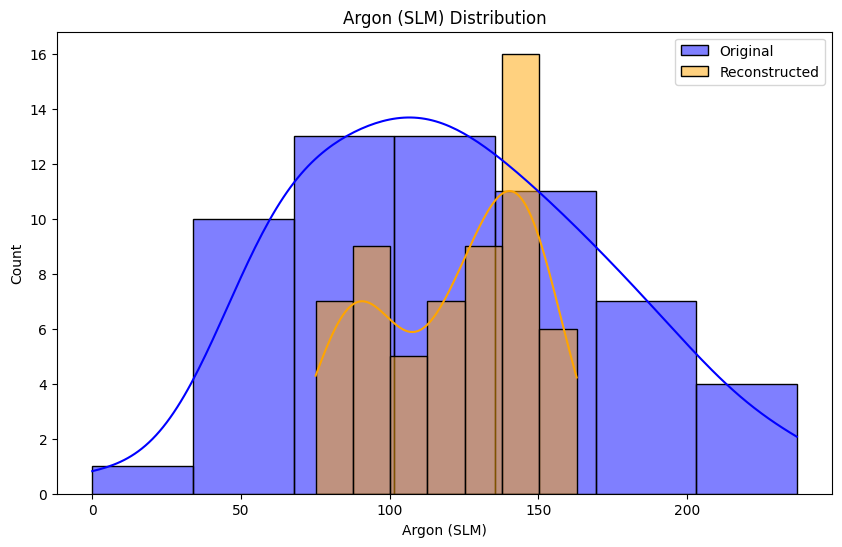

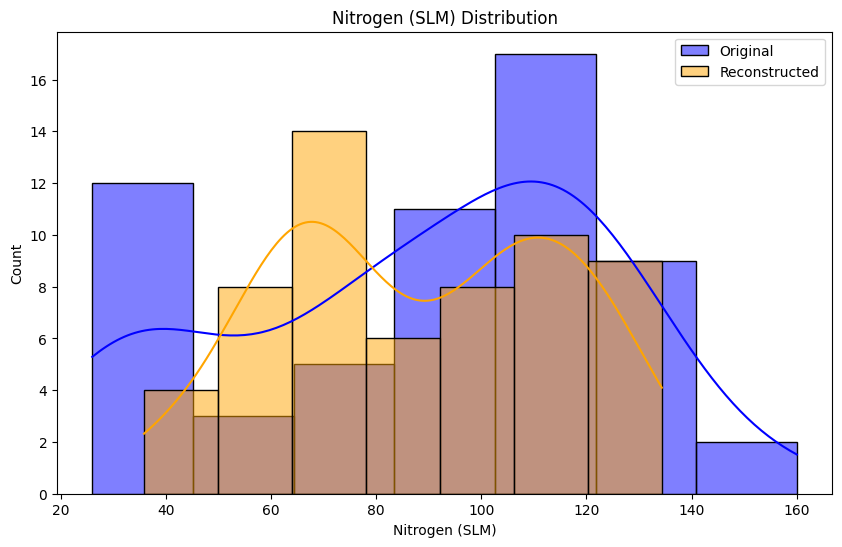

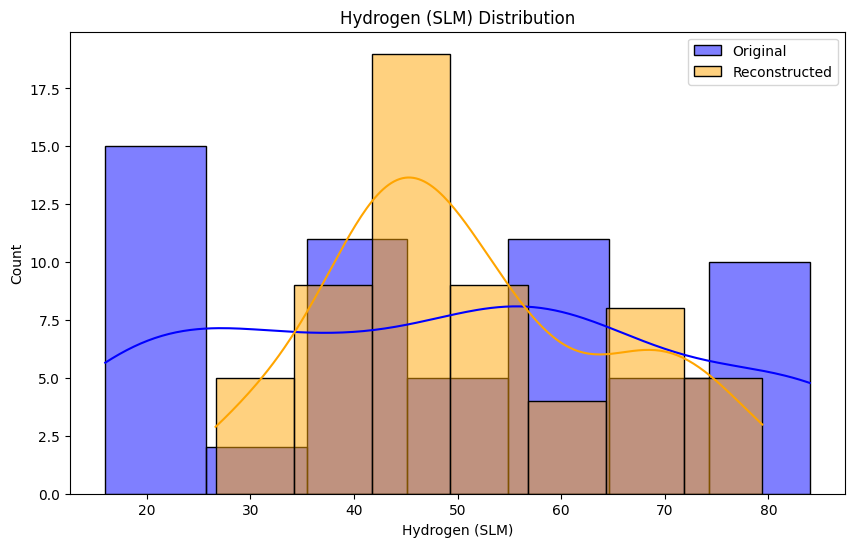

In [48]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Function to reconstruct data
def reconstruct_data(gpp_cvae, train_dataloader):
    original_data = []
    reconstructed_data = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in train_dataloader:
            recon_batch, _, _, _ = gpp_cvae(batch_features, batch_conditions)
            original_data.append(batch_features)
            reconstructed_data.append(recon_batch)
    original_data = torch.cat(original_data, dim=0).cpu().numpy()
    reconstructed_data = torch.cat(reconstructed_data, dim=0).cpu().numpy()
    original_data = scaler_features.inverse_transform(original_data)
    reconstructed_data = scaler_features.inverse_transform(reconstructed_data)
    return original_data, reconstructed_data

# Reconstruct data
original_data, reconstructed_data = reconstruct_data(gpp_cvae, train_dataloader)

# Plotting function for individual gas variables
def plot_distribution(original, reconstructed, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(original, kde=True, color='blue', alpha=0.5, label='Original')
    sns.histplot(reconstructed, kde=True, color='orange', alpha=0.5, label='Reconstructed')
    plt.title(f'{feature_name} Distribution')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Plot distributions for Argon (Ar_un), Nitrogen (N2_un), and Hydrogen (H2_un)
plot_distribution(original_data[:, 0], reconstructed_data[:, 0], 'Argon (SLM)')
plot_distribution(original_data[:, 1], reconstructed_data[:, 1], 'Nitrogen (SLM)')
plot_distribution(original_data[:, 2], reconstructed_data[:, 2], 'Hydrogen (SLM)')


Cp = (1 - x) * find_closest_cp(temp2, cp_zro2) + x * find_closest_cp(temp2, cp_y2o3)

Cp

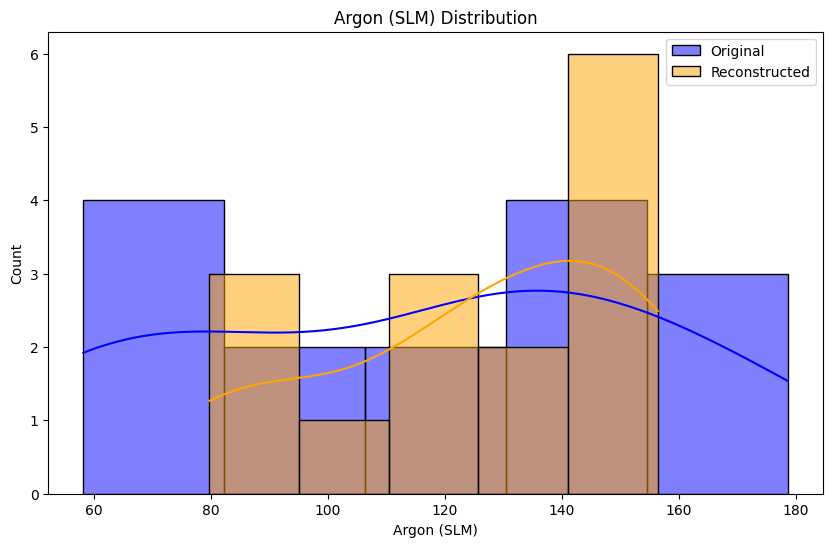

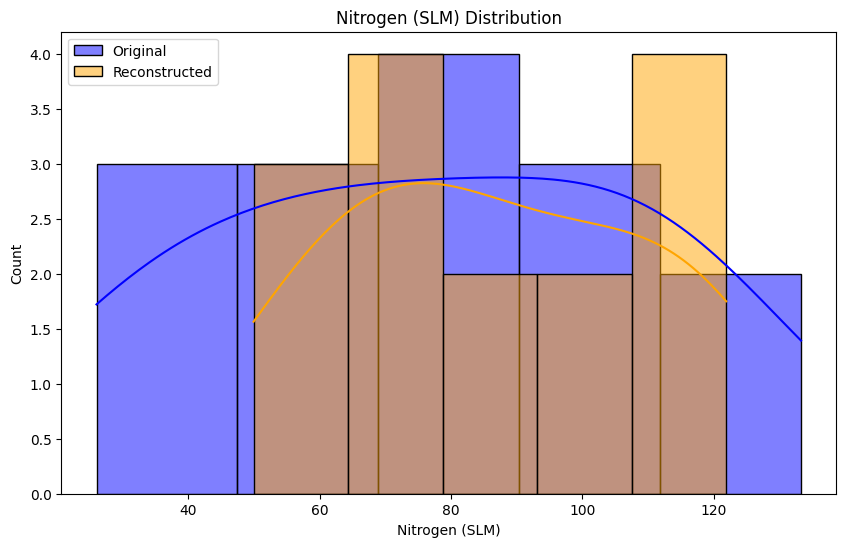

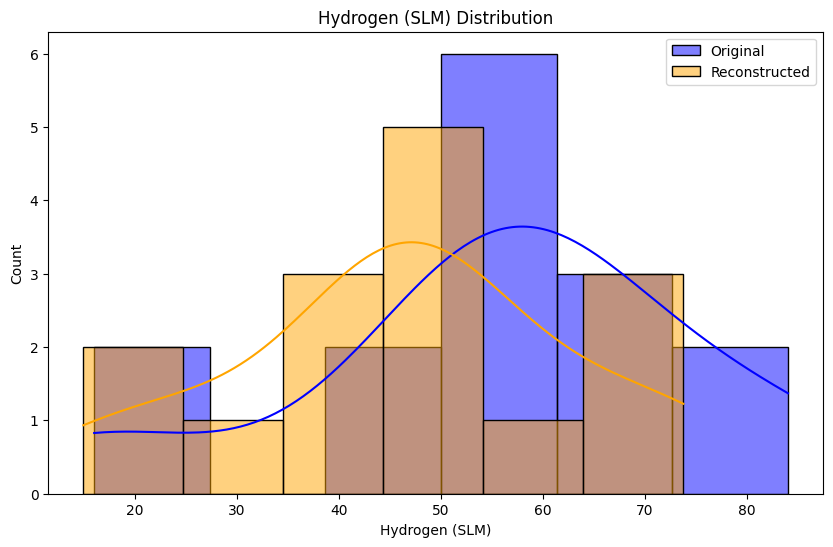

In [49]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Function to reconstruct data
def reconstruct_data(gpp_cvae, test_dataloader):
    original_data = []
    reconstructed_data = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in test_dataloader:
            recon_batch, _, _, _ = gpp_cvae(batch_features, batch_conditions)
            original_data.append(batch_features)
            reconstructed_data.append(recon_batch)
    original_data = torch.cat(original_data, dim=0).cpu().numpy()
    reconstructed_data = torch.cat(reconstructed_data, dim=0).cpu().numpy()
    original_data = scaler_features.inverse_transform(original_data)
    reconstructed_data = scaler_features.inverse_transform(reconstructed_data)
    return original_data, reconstructed_data

# Reconstruct data
original_data, reconstructed_data = reconstruct_data(gpp_cvae, test_dataloader)

# Plotting function for individual gas variables
def plot_distribution(original, reconstructed, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(original, kde=True, color='blue', alpha=0.5, label='Original')
    sns.histplot(reconstructed, kde=True, color='orange', alpha=0.5, label='Reconstructed')
    plt.title(f'{feature_name} Distribution')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Plot distributions for Argon (Ar_un), Nitrogen (N2_un), and Hydrogen (H2_un)
plot_distribution(original_data[:, 0], reconstructed_data[:, 0], 'Argon (SLM)')
plot_distribution(original_data[:, 1], reconstructed_data[:, 1], 'Nitrogen (SLM)')
plot_distribution(original_data[:, 2], reconstructed_data[:, 2], 'Hydrogen (SLM)')


In [50]:
features_train_unc= torch.tensor(features_train, dtype=torch.float32)
conditions_train_unc= torch.tensor(conditions_train, dtype=torch.float32)

In [51]:
features_train_unc= torch.tensor(features_train, dtype=torch.float32)
conditions_train_unc= torch.tensor(conditions_train, dtype=torch.float32)
import torch

# Ensure your model is in evaluation mode
gpp_cvae.eval()

# Get latent space representations for your entire dataset
with torch.no_grad():
    mu, logvar = gpp_cvae.encoder(features_train_tensor, conditions_train_tensor)
    z = gpp_cvae.reparameterize(mu, logvar)

# Calculate uncertainty using the Gaussian Process model
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = gpp_cvae.gp_model(z)
    mean = predictions.mean
    variance = predictions.variance
    std_dev = variance.sqrt()

# Convert to numpy for easier handling
z = z.cpu().numpy()
mean = mean.cpu().numpy()
std_dev = std_dev.cpu().numpy()

In [52]:
mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [53]:
std_dev

array([0.12244692, 0.06925766, 0.03319774, 0.1681685 , 0.1878649 ,
       0.04096546, 0.02230783, 0.21354191, 0.03119082, 0.07338771,
       0.02771507, 0.4860027 , 0.0353431 , 0.05508388, 0.0796531 ,
       0.03510705, 0.04083284, 0.07581972, 0.02492029, 0.11926863,
       0.02821277, 0.03994368, 0.09045237, 0.0461148 , 0.5680181 ,
       0.10015778, 0.46652755, 0.07562214, 0.04522339, 0.0447677 ,
       0.02908042, 0.22503383, 0.03263823, 0.0646664 , 0.11082962,
       0.03753657, 0.04283816, 0.04075247, 0.05710803, 0.17015305,
       0.04297569, 0.02700487, 0.08202399, 0.03529331, 0.05184238,
       0.0379189 , 0.04406924, 0.03388193, 0.0442326 , 0.27992615,
       0.0298651 , 0.03560103, 0.05097982, 0.02804325, 0.03311054,
       0.04735133, 0.02198486, 0.0315159 , 0.08312406], dtype=float32)

In [54]:
a = pd.DataFrame(features_train, columns = ['Argon','Nitrogen','Hydrogen'])
b = pd.DataFrame(conditions_train, columns = ['BP(°C)', 'PS', 'Mean Particle Temperature (°C)','Cp'])
unc = a.join(b)
unc.head()

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp
0,87.0000,129.0000,84.0000,100.00,3.34,2779.500000,120.34
1,192.0000,84.0000,24.0000,78.37,0.45,2906.527627,120.34
2,172.5000,32.5000,45.0000,78.37,0.45,2837.090000,120.34
3,59.3094,112.8094,59.4408,100.00,3.34,2796.225000,120.34
4,128.0000,56.0000,16.0000,78.37,0.45,2828.845932,120.34


In [55]:
unc['unc'] = std_dev

In [56]:
unc['unc'].describe()

count    59.000000
mean      0.089805
std       0.112045
min       0.021985
25%       0.034494
50%       0.044768
75%       0.082574
max       0.568018
Name: unc, dtype: float64

In [57]:
unc.head(),unc.columns

(      Argon  Nitrogen  Hydrogen  BP(°C)    PS  Mean Particle Temperature (°C)  \
 0   87.0000  129.0000   84.0000  100.00  3.34                     2779.500000   
 1  192.0000   84.0000   24.0000   78.37  0.45                     2906.527627   
 2  172.5000   32.5000   45.0000   78.37  0.45                     2837.090000   
 3   59.3094  112.8094   59.4408  100.00  3.34                     2796.225000   
 4  128.0000   56.0000   16.0000   78.37  0.45                     2828.845932   
 
        Cp       unc  
 0  120.34  0.122447  
 1  120.34  0.069258  
 2  120.34  0.033198  
 3  120.34  0.168169  
 4  120.34  0.187865  ,
 Index(['Argon', 'Nitrogen', 'Hydrogen', 'BP(°C)', 'PS',
        'Mean Particle Temperature (°C)', 'Cp', 'unc'],
       dtype='object'))

In [58]:
# Filter rows where 'BP(°C)' for water
unc_water = unc[unc['BP(°C)'] == 100]

# Filter rows where 'BP(°C)' for ethanol
unc_eth = unc[unc['BP(°C)'] == 78.37]


In [59]:
unc_eth

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp,unc
1,192.000,84.000,24.000,78.37,0.45,2906.527627,120.34,0.069258
2,172.500,32.500,45.000,78.37,0.45,2837.090000,120.34,0.033198
4,128.000,56.000,16.000,78.37,0.45,2828.845932,120.34,0.187865
5,161.827,106.057,36.578,78.37,0.45,3065.151100,137.16,0.040965
8,118.000,26.000,56.000,78.37,0.45,2740.116271,120.34,0.031191
9,117.000,129.000,54.000,78.37,0.45,2983.194068,138.08,0.073388
11,237.000,39.000,24.000,78.37,0.45,2851.179153,120.34,0.486003
12,108.000,56.000,36.000,78.37,0.45,2821.636034,120.34,0.035343
14,197.500,32.500,20.000,78.37,0.45,2747.245932,120.34,0.079653
15,122.500,107.500,20.000,78.37,0.45,2916.911724,120.34,0.035107


In [101]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

# Assume unc_water DataFrame is already loaded with appropriate columns

# Extract the necessary columns from the dataset
X = unc_water[['Argon', 'Nitrogen', 'Hydrogen', 'Mean Particle Temperature (°C)']].values
y = unc_water['unc'].values  # This is the std_dev, i.e., uncertainty (you already have this)

# Normalize the input features (Argon, Nitrogen, Hydrogen, Temp) using MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Define your unnormalize function
def unnormalize(value, min_val, max_val):
    return min_val + value * (max_val - min_val)

# Store the min and max values for each feature from the scaler (for unnormalization later)
min_vals = scaler.data_min_
max_vals = scaler.data_max_

def expected_improvement(sigma, best_f):
    """
    Calculate the Expected Improvement for a set of candidate points.
    
    Parameters:
    - sigma: Standard deviation of the predictions (uncertainty).
    - best_f: The best observed function value (minimum uncertainty).
    
    Returns:
    - EI: Expected Improvement for each candidate point.
    """
    Z = best_f / sigma
    EI = sigma * (Z * norm.cdf(Z) + norm.pdf(Z))
    return EI

def apply_constraints(new_data, gas_ranges=None):
    """
    Apply constraints to the sampled data points and filter based on specified gas ranges.
    
    Parameters:
    - new_data: Array of new sampled data points.
    - gas_ranges: Optional dictionary specifying the min and max range for each gas.
                  e.g., {'Ar': (min_Ar, max_Ar), 'N2': (min_N2, max_N2), 'H2': (min_H2, max_H2)}
    
    Returns:
    - valid_data: Array of valid data points after applying constraints and gas range filters.
    """
    valid_data = []
    for data_point in new_data:
        Ar_un, N2_un, H2_un, Temp = data_point  # Adjusted to handle the temperature as well
        Total_flow = Ar_un + N2_un + H2_un
        frac_N2 = N2_un / Total_flow
        frac_H2 = H2_un / Total_flow

        # Check if the point satisfies the flow constraints
        if not (Total_flow >= 130 and Total_flow <= 350 and frac_N2 <= 0.8 and frac_H2 <= 0.28):
            continue

        # Check if the point satisfies the specified gas ranges
        if gas_ranges:
            if not (gas_ranges['Ar'][0] <= Ar_un <= gas_ranges['Ar'][1] and
                    gas_ranges['N2'][0] <= N2_un <= gas_ranges['N2'][1] and
                    gas_ranges['H2'][0] <= H2_un <= gas_ranges['H2'][1]):
                continue

        valid_data.append(data_point)

    return np.array(valid_data)

def optimize_expected_improvement(X_existing_scaled, y_existing_unc, bounds, gas_ranges=None, top_n=5, n_samples=100000):

    n_features = bounds.shape[0]
    
    # Sample new points within the parameter space
    lhs_samples = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_samples, n_features))
    
    # Unnormalize sampled points to apply constraints and range filtering
    lhs_samples_unnorm = np.array([unnormalize(lhs_samples[:, i], min_vals[i], max_vals[i]) for i in range(n_features)]).T
    
    # Apply constraints and gas range filters to valid points
    valid_samples = apply_constraints(lhs_samples_unnorm, gas_ranges)
    
    if valid_samples.size == 0:
        raise ValueError("No valid samples found after applying constraints and gas range filters.")
    
    # Normalize valid points back for EI calculation
    valid_samples_scaled = scaler.transform(valid_samples)
    
    # Find the best observed function value (smallest uncertainty)
    best_f = np.min(y_existing_unc)
    
    # Use the existing variance (standard deviation) as sigma for each valid sample
    sigma = y_existing_unc  # Assuming this represents the uncertainty (standard deviation)
    
    # Calculate Expected Improvement for each valid sample
    EI = expected_improvement(sigma, best_f)
    
    # Sort the valid samples by Expected Improvement in descending order and select the top_n points
    sorted_indices = np.argsort(EI)[-top_n:]
    X_top_n = valid_samples_scaled[sorted_indices]
    
    return X_top_n

# Define the bounds for each parameter (normalized values), now including Temp
bounds = np.array([
    [0, 1],  # Argon
    [0, 1],  # Nitrogen
    [0, 1],  # Hydrogen
    [0, 1]   # Temp
])

# Define the desired gas ranges (optional)
gas_ranges = {
    'Ar': (50, 100),    # Example range for Argon
    'N2': (30, 80),     # Example range for Nitrogen
    'H2': (10, 50)      # Example range for Hydrogen
}

# Run the optimization to select the top 5 data points based on Expected Improvement
X_top_5_ei = optimize_expected_improvement(X_scaled, y, bounds, gas_ranges=gas_ranges, top_n=5)

# Unnormalize the selected points to obtain real-world values
unnormalized_points_ei = []
for i, X_next in enumerate(X_top_5_ei):
    best_Ar = unnormalize(X_next[0], min_vals[0], max_vals[0])
    best_N2 = unnormalize(X_next[1], min_vals[1], max_vals[1])
    best_H2 = unnormalize(X_next[2], min_vals[2], max_vals[2])
    best_Temp = unnormalize(X_next[3], min_vals[3], max_vals[3])
    unnormalized_points_ei.append([best_Ar, best_N2, best_H2, best_Temp])
    print(f"Data Point {i+1}: Ar={best_Ar}, N2={best_N2}, H2={best_H2}, Temp={best_Temp}")

# Print the final results as a list of unnormalized points
print("Top 5 data points based on Expected Improvement (unnormalized):")
for i, point in enumerate(unnormalized_points_ei):
    print(f"Point {i+1}: {point}")


Data Point 1: Ar=90.33846127629039, N2=62.430465433482034, H2=40.23803694950293, Temp=2885.6412510339987
Data Point 2: Ar=80.17218621354884, N2=50.05921988432347, H2=31.18562372611248, Temp=2862.839411853618
Data Point 3: Ar=70.98400070273675, N2=74.05608819393547, H2=18.751699045344893, Temp=2830.4703279310183
Data Point 4: Ar=92.71805728800788, N2=68.71571524123343, H2=26.657954989114057, Temp=2638.140097088312
Data Point 5: Ar=85.37649229226479, N2=65.53870558593913, H2=41.17979227309662, Temp=2749.169516635813
Top 5 data points based on Expected Improvement (unnormalized):
Point 1: [90.33846127629039, 62.430465433482034, 40.23803694950293, 2885.6412510339987]
Point 2: [80.17218621354884, 50.05921988432347, 31.18562372611248, 2862.839411853618]
Point 3: [70.98400070273675, 74.05608819393547, 18.751699045344893, 2830.4703279310183]
Point 4: [92.71805728800788, 68.71571524123343, 26.657954989114057, 2638.140097088312]
Point 5: [85.37649229226479, 65.53870558593913, 41.17979227309662, 

In [64]:
# The new unnormalized data points provided
unnormalized_data_points = [
[128.621514588222, 56.43404947324034, 20.99292246222339, 2694.8181760263683],
[173.65648403273707, 35.43023946071728, 29.138708407195008, 2676.7906833905736],
[166.90923560497652, 30.626057191781562, 16.92594938655456, 2670.7181965857303],
[146.23305039560424, 63.04621882086412, 20.56785130616436, 2684.1928089011917],
[118.78654229914095, 26.137743492971452, 18.38411980963069, 2711.500867329281]
]

# Columns for the unnormalized dataset
columns = ['Argon', 'Nitrogen', 'Hydrogen', 'Mean Particle Temperature (°C)']

# Create a DataFrame for the unnormalized data points
df_unnormalized_points = pd.DataFrame(unnormalized_data_points, columns=columns)

# Append the unnormalized data points to the existing dataset
unc_eth_al = pd.concat([unc_eth, df_unnormalized_points], ignore_index=True)

In [65]:
unc_eth_al

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp,unc
0,192.000000,84.000000,24.000000,78.37,0.45,2906.527627,120.34,0.069258
1,172.500000,32.500000,45.000000,78.37,0.45,2837.090000,120.34,0.033198
2,128.000000,56.000000,16.000000,78.37,0.45,2828.845932,120.34,0.187865
3,161.827000,106.057000,36.578000,78.37,0.45,3065.151100,137.16,0.040965
4,118.000000,26.000000,56.000000,78.37,0.45,2740.116271,120.34,0.031191
5,117.000000,129.000000,54.000000,78.37,0.45,2983.194068,138.08,0.073388
6,237.000000,39.000000,24.000000,78.37,0.45,2851.179153,120.34,0.486003
7,108.000000,56.000000,36.000000,78.37,0.45,2821.636034,120.34,0.035343
8,197.500000,32.500000,20.000000,78.37,0.45,2747.245932,120.34,0.079653
9,122.500000,107.500000,20.000000,78.37,0.45,2916.911724,120.34,0.035107


In [155]:
df_unnormalized_points

,Argon,Nitrogen,Hydrogen,Mean Particle Temperature (°C)
0,184.598430,98.651272,24.141651,2681.093230
1,218.382552,103.547478,31.713246,2672.343176
2,208.986653,63.532670,22.020513,2681.849091
3,167.512310,91.552148,25.427992,2688.017618
4,165.183969,27.357203,16.026197,2766.169958
5,221.635499,39.047097,18.081385,2740.231053
6,228.292449,61.898044,36.612099,2696.956610
7,216.710140,67.918296,25.890088,2670.778445
8,225.464093,29.027366,17.972908,2699.319407
9,216.601320,68.659673,38.868039,2667.835749


In [66]:
# The new data points provided
new_data_points = [
[106.70966048406513, 49.61188126334021, 25.798778755839734, 2841.225209111818],
[111.31234693034439, 114.4863366500644, 59.72278987543041, 2853.750843606734],
[75.60803903447051, 96.3350037632959, 62.6575006932978, 2657.2124683881434],
[180.18439052048384, 124.42715929783026, 38.76841779472774, 2583.9174802150637],
[179.54596241691866, 77.05692714693599, 38.814600722568414, 2659.225277378606]
]

# The columns for the dataset
columns = ['Argon', 'Nitrogen', 'Hydrogen', 'Mean Particle Temperature (°C)']

# Create a DataFrame for the new data points
df_new_top_points = pd.DataFrame(new_data_points, columns=columns)

# Append the new data points to the existing dataset
unc_water_al = pd.concat([unc_water, df_new_top_points], ignore_index=True)

In [180]:
df_new_top_points

,Argon,Nitrogen,Hydrogen,Mean Particle Temperature (°C)
0,149.653625,104.216362,61.239839,2823.987820
1,173.113613,86.614132,79.284434,2561.628542
2,126.226345,71.546370,82.712620,2891.715469
3,202.797084,95.535966,60.747919,2715.414042
4,170.762821,99.945973,83.170742,2654.859786
5,123.075173,95.312787,76.455436,2733.470998
6,148.219740,77.515850,83.134563,2512.677702
7,133.119658,87.227912,73.860642,2662.663815
8,173.410216,89.516905,68.410626,2874.230051
9,167.982633,71.805754,66.587368,2879.885888


In [298]:
unc_eth_al

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp,unc
0,192.000000,84.000000,24.000000,78.37,0.45,2906.527627,120.34,0.036759
1,172.500000,32.500000,45.000000,78.37,0.45,2837.090000,120.34,0.034073
2,128.000000,56.000000,16.000000,78.37,0.45,2828.845932,120.34,0.047757
3,161.827000,106.057000,36.578000,78.37,0.45,3065.151100,137.16,0.042405
4,118.000000,26.000000,56.000000,78.37,0.45,2740.116271,120.34,0.033046
5,117.000000,129.000000,54.000000,78.37,0.45,2983.194068,138.08,0.033563
6,237.000000,39.000000,24.000000,78.37,0.45,2851.179153,120.34,0.031589
7,108.000000,56.000000,36.000000,78.37,0.45,2821.636034,120.34,0.152217
8,197.500000,32.500000,20.000000,78.37,0.45,2747.245932,120.34,0.264377
9,122.500000,107.500000,20.000000,78.37,0.45,2916.911724,120.34,0.038965


In [67]:
al_df = pd.concat([unc_water_al,unc_eth_al], ignore_index=True)

In [68]:
al_df

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp,unc
0,87.000000,129.000000,84.000000,100.0,3.34,2779.500000,120.34,0.122447
1,59.309400,112.809400,59.440800,100.0,3.34,2796.225000,120.34,0.168169
2,147.000000,129.000000,24.000000,100.0,3.34,2689.800000,120.34,0.022308
3,58.000000,112.150300,58.985200,100.0,3.34,2791.747000,120.34,0.213542
4,160.000000,70.000000,20.000000,100.0,3.34,2550.700000,120.34,0.027715
...,...,...,...,...,...,...,...,...
64,128.621515,56.434049,20.992922,NaN,NaN,2694.818176,NaN,NaN
65,173.656484,35.430239,29.138708,NaN,NaN,2676.790683,NaN,NaN
66,166.909236,30.626057,16.925949,NaN,NaN,2670.718197,NaN,NaN
67,146.233050,63.046219,20.567851,NaN,NaN,2684.192809,NaN,NaN


In [169]:
unc

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp,unc
0,87.00000,129.0000,84.0000,100.00,3.34,2779.500000,120.34,0.059092
1,192.00000,84.0000,24.0000,78.37,0.45,2906.527627,120.34,0.036759
2,172.50000,32.5000,45.0000,78.37,0.45,2837.090000,120.34,0.034073
3,59.30940,112.8094,59.4408,100.00,3.34,2796.225000,120.34,0.028479
4,128.00000,56.0000,16.0000,78.37,0.45,2828.845932,120.34,0.047757
5,161.82700,106.0570,36.5780,78.37,0.45,3065.151100,137.16,0.042405
6,147.00000,129.0000,24.0000,100.00,3.34,2689.800000,120.34,0.574621
7,58.00000,112.1503,58.9852,100.00,3.34,2791.747000,120.34,0.033729
8,118.00000,26.0000,56.0000,78.37,0.45,2740.116271,120.34,0.033046
9,117.00000,129.0000,54.0000,78.37,0.45,2983.194068,138.08,0.033563


In [69]:
al_df = al_df.drop(['Cp','unc'], axis = 1)
al_df

,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C)
0,87.000000,129.000000,84.000000,100.0,3.34,2779.500000
1,59.309400,112.809400,59.440800,100.0,3.34,2796.225000
2,147.000000,129.000000,24.000000,100.0,3.34,2689.800000
3,58.000000,112.150300,58.985200,100.0,3.34,2791.747000
4,160.000000,70.000000,20.000000,100.0,3.34,2550.700000
...,...,...,...,...,...,...
64,128.621515,56.434049,20.992922,NaN,NaN,2694.818176
65,173.656484,35.430239,29.138708,NaN,NaN,2676.790683
66,166.909236,30.626057,16.925949,NaN,NaN,2670.718197
67,146.233050,63.046219,20.567851,NaN,NaN,2684.192809


In [70]:
al_df = al_df.ffill()

In [71]:
al_df.columns

Index(['Argon', 'Nitrogen', 'Hydrogen', 'BP(°C)', 'PS',
       'Mean Particle Temperature (°C)'],
      dtype='object')

In [72]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = 'final_data_finale4.csv'
data = al_df

# Function to find the closest temperature and return the corresponding Cp value
def find_closest_cp(temp, cp_table):
    cp_table['Temp_diff'] = abs(cp_table['T'] - temp)
    closest_row = cp_table.loc[cp_table['Temp_diff'].idxmin()]
    return closest_row['Cp']

# Create Cp tables for Y2O3 and ZrO2
cp_y2o3 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1330, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [102.5, 102.8, 113.0, 118.1, 121.1, 123.2, 124.7, 125.9, 127.0, 127.9, 128.8, 129.6, 129.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 131.8, 137.6, 152.4, 151.8, 160.1, 161.1]
})

cp_zro2 = pd.DataFrame({
    'T': [298.15, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1478, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 2950, 3000, 3100, 3200, 3300],
    'Cp': [56.1, 56.3, 63.8, 67.6, 70.2, 72.0, 73.5, 74.7, 75.7, 76.6, 77.7, 78.6, 79.5, 80.8, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 74.5, 87.9, 80.8, 78.6, 75.1, 74.5]
})


temp_column = 'Mean Particle Temperature (°C)'  # Assuming this is the column for temperature
x = 0.8  # Proportion for Y2O3

# Add the new Cp column to the dataset
al_df['Cp'] = al_df[temp_column].apply(lambda temp: (1 - x) * find_closest_cp(temp, cp_zro2) + x * find_closest_cp(temp, cp_y2o3))

al_df.head()


,Argon,Nitrogen,Hydrogen,BP(°C),PS,Mean Particle Temperature (°C),Cp
0,87.0000,129.0000,84.0000,100.0,3.34,2779.500,120.34
1,59.3094,112.8094,59.4408,100.0,3.34,2796.225,120.34
2,147.0000,129.0000,24.0000,100.0,3.34,2689.800,120.34
3,58.0000,112.1503,58.9852,100.0,3.34,2791.747,120.34
4,160.0000,70.0000,20.0000,100.0,3.34,2550.700,120.34


In [73]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

# Separate the conditions (BP, PS, MP, SPC) and the features (Ar_un, N2_un, H2_un)
conditions = al_df[['BP(°C)', 'PS', 'Mean Particle Temperature (°C)','Cp']].values
features = al_df[['Argon', 'Nitrogen', 'Hydrogen']].values

In [74]:
from sklearn.model_selection import train_test_split

# Standardize the data
scaler_features = MinMaxScaler()
scaler_conditions = MinMaxScaler()

features_train_scaled = scaler_features.fit_transform(features)

conditions_train_scaled = scaler_conditions.fit_transform(conditions)


# Convert data to PyTorch tensors
features_train_tensor = torch.tensor(features_train_scaled, dtype=torch.float32)

conditions_train_tensor = torch.tensor(conditions_train_scaled, dtype=torch.float32)


# Create DataLoader for training data
train_dataset = TensorDataset(features_train_tensor, conditions_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [75]:
import torch.nn as nn
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim + cond_dim, 512)
        self.fc2 = nn.Linear(512, 216)
        self.fc3 = nn.Linear(216, 120)
        self.fc4 = nn.Linear(120, 64)
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

    def forward(self, x, c):
        x = torch.cat([x, c], dim=1)  # Concatenate input data and conditions
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, cond_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim + cond_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, z, c):
        z = torch.cat([z, c], dim=1)  # Concatenate latent variables and conditions
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        z = self.fc3(z)
        return z

class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class GPP_CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super(GPP_CVAE, self).__init__()
        self.encoder = Encoder(input_dim, latent_dim, cond_dim)
        self.decoder = Decoder(latent_dim, input_dim, cond_dim)
        self.likelihood = GaussianLikelihood()
        self.gp_model = None
        self.train_x = None
        self.train_y = None
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, c):
        mu, logvar = self.encoder(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z, c)
        return recon_x, mu, logvar, z

    def set_gp_model(self, train_x, train_y):
        self.train_x = train_x
        self.train_y = train_y
        self.gp_model = GPModel(train_x, train_y, self.likelihood)
        
    def gp_prior_loss(self, z):
        if self.gp_model is None:
            raise ValueError("GP model is not initialized.")
        self.gp_model.train()
        self.likelihood.train()
        mll = ExactMarginalLogLikelihood(self.likelihood, self.gp_model)
        output = self.gp_model(self.train_x)
        return -mll(output, self.train_y)

    def loss_function(self, recon_x, x, mu, logvar, z):
        BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        GP_prior_loss = self.gp_prior_loss(z)
        return BCE + KLD + GP_prior_loss


In [76]:
def optimize_gp_hyperparameters(gp_model, train_x, train_y, learning_rate=0.1, num_steps=50):
    gp_model.train()
    optimizer = torch.optim.Adam(gp_model.parameters(), lr=learning_rate)
    mll = ExactMarginalLogLikelihood(gp_model.likelihood, gp_model)
    
    for step in range(num_steps):
        optimizer.zero_grad()
        output = gp_model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        print(f'Step {step+1}/{num_steps}, Loss: {loss.item()}')
    
    return gp_model

def initialize_and_optimize_gp_model(gpp_cvae, train_dataloader , learning_rate=0.1, num_steps=50):
    all_z = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in train_dataloader:
            _, _, _, z = gpp_cvae(batch_features, batch_conditions)
            all_z.append(z)
    all_z = torch.cat(all_z, dim=0)
    train_x = all_z
    train_y = torch.zeros(train_x.size(0))  # Dummy values for initialization
    gpp_cvae.set_gp_model(train_x, train_y)
    
    # Optimize GP hyperparameters
    optimized_gp_model = optimize_gp_hyperparameters(gpp_cvae.gp_model, train_x, train_y, learning_rate, num_steps)
    gpp_cvae.set_gp_model(train_x, train_y)  # Update the model with optimized GP
    return gpp_cvae


In [77]:
import torch.optim as optim
# Set parameters
input_dim = features_train_scaled.shape[1]
latent_dim = 2
cond_dim = conditions_train_scaled.shape[1]
lr = 1e-3
num_epochs = 100

# Create model
gpp_cvae = GPP_CVAE(input_dim, latent_dim, cond_dim)

# Initialize and optimize the GP model with actual data
gpp_cvae = initialize_and_optimize_gp_model(gpp_cvae, train_dataloader , learning_rate=0.1, num_steps=50)

optimizer = optim.Adam(gpp_cvae.parameters(), lr=lr)

# Training loop
for epoch in range(num_epochs):
    gpp_cvae.train()
    train_loss = 0
    for batch_features, batch_conditions in train_dataloader:
        optimizer.zero_grad()
        recon_batch, mu, logvar, z = gpp_cvae(batch_features, batch_conditions)
        loss = gpp_cvae.loss_function(recon_batch, batch_features, mu, logvar, z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    average_loss = train_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}')

Step 1/50, Loss: 0.913835883140564
Step 2/50, Loss: 0.8693172931671143
Step 3/50, Loss: 0.8243213891983032
Step 4/50, Loss: 0.77888423204422
Step 5/50, Loss: 0.7330352067947388
Step 6/50, Loss: 0.6867992281913757
Step 7/50, Loss: 0.6401957869529724
Step 8/50, Loss: 0.5932402610778809
Step 9/50, Loss: 0.5459432005882263
Step 10/50, Loss: 0.4983116388320923
Step 11/50, Loss: 0.45034927129745483
Step 12/50, Loss: 0.40205860137939453
Step 13/50, Loss: 0.3534417748451233
Step 14/50, Loss: 0.30450117588043213
Step 15/50, Loss: 0.25524044036865234
Step 16/50, Loss: 0.20566436648368835
Step 17/50, Loss: 0.15577952563762665
Step 18/50, Loss: 0.10559374839067459
Step 19/50, Loss: 0.05511729046702385
Step 20/50, Loss: 0.004360420163720846
Step 21/50, Loss: -0.04666386544704437
Step 22/50, Loss: -0.09794224053621292
Step 23/50, Loss: -0.1494607776403427
Step 24/50, Loss: -0.20120388269424438
Step 25/50, Loss: -0.2531561851501465
Step 26/50, Loss: -0.30530187487602234
Step 27/50, Loss: -0.357624828

In [78]:
    gpp_cvae.eval()  # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch_features, batch_conditions in test_dataloader:
            # Forward pass
            recon_batch, mu, logvar, z = gpp_cvae(batch_features, batch_conditions)
            
            # Calculate loss (without backpropagation)
            loss = gpp_cvae.loss_function(recon_batch, batch_features, mu, logvar, z)
            
            # Accumulate test loss
            test_loss += loss.item()
    
    # Compute average test loss for the epoch
    average_test_loss = test_loss / len(test_dataloader.dataset)
average_test_loss

0.10134318669637045

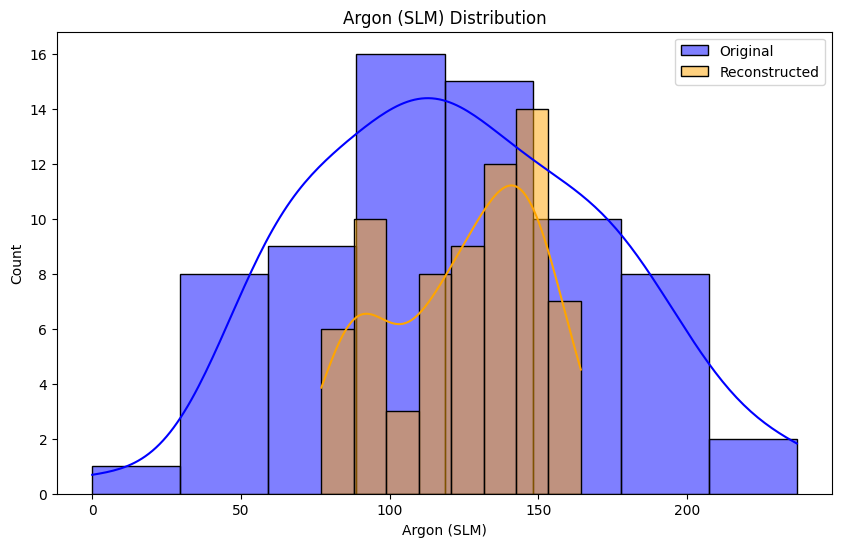

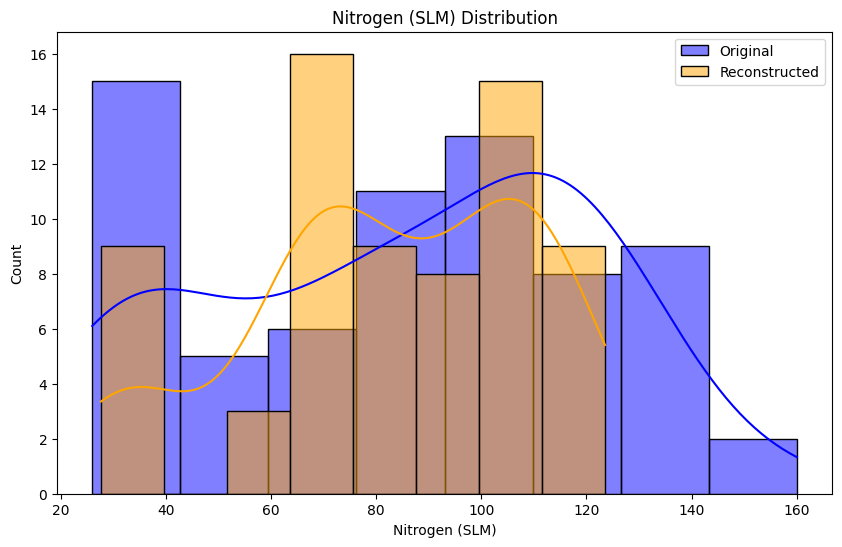

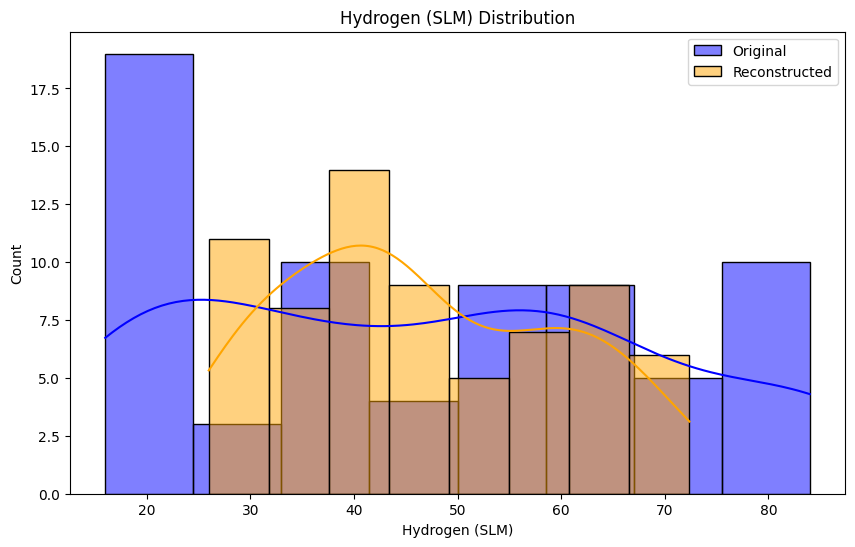

In [79]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Function to reconstruct data
def reconstruct_data(gpp_cvae, train_dataloader):
    original_data = []
    reconstructed_data = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in train_dataloader:
            recon_batch, _, _, _ = gpp_cvae(batch_features, batch_conditions)
            original_data.append(batch_features)
            reconstructed_data.append(recon_batch)
    original_data = torch.cat(original_data, dim=0).cpu().numpy()
    reconstructed_data = torch.cat(reconstructed_data, dim=0).cpu().numpy()
    original_data = scaler_features.inverse_transform(original_data)
    reconstructed_data = scaler_features.inverse_transform(reconstructed_data)
    return original_data, reconstructed_data

# Reconstruct data
original_data, reconstructed_data = reconstruct_data(gpp_cvae, train_dataloader)

# Plotting function for individual gas variables
def plot_distribution(original, reconstructed, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(original, kde=True, color='blue', alpha=0.5, label='Original')
    sns.histplot(reconstructed, kde=True, color='orange', alpha=0.5, label='Reconstructed')
    plt.title(f'{feature_name} Distribution')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Plot distributions for Argon (Ar_un), Nitrogen (N2_un), and Hydrogen (H2_un)
plot_distribution(original_data[:, 0], reconstructed_data[:, 0], 'Argon (SLM)')
plot_distribution(original_data[:, 1], reconstructed_data[:, 1], 'Nitrogen (SLM)')
plot_distribution(original_data[:, 2], reconstructed_data[:, 2], 'Hydrogen (SLM)')


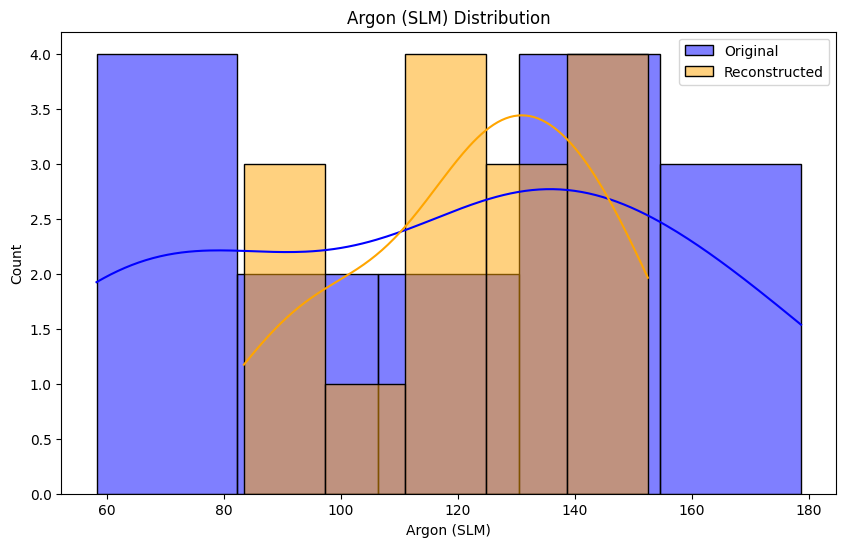

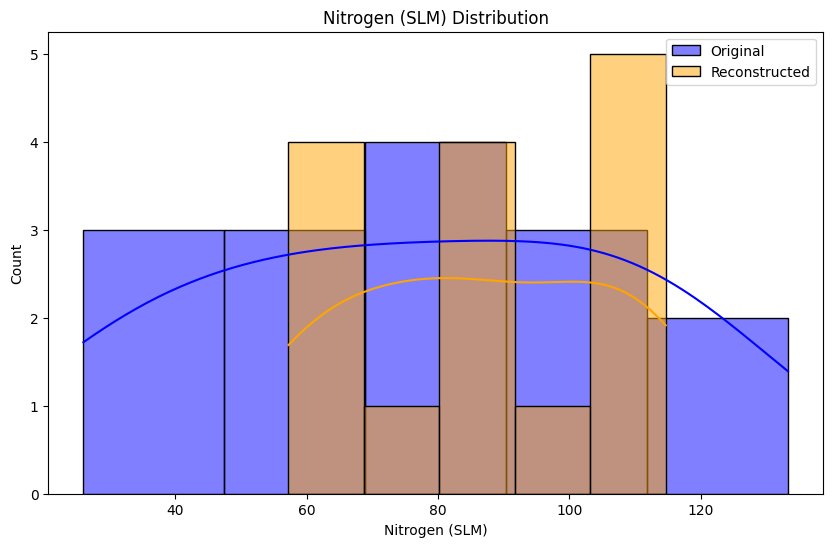

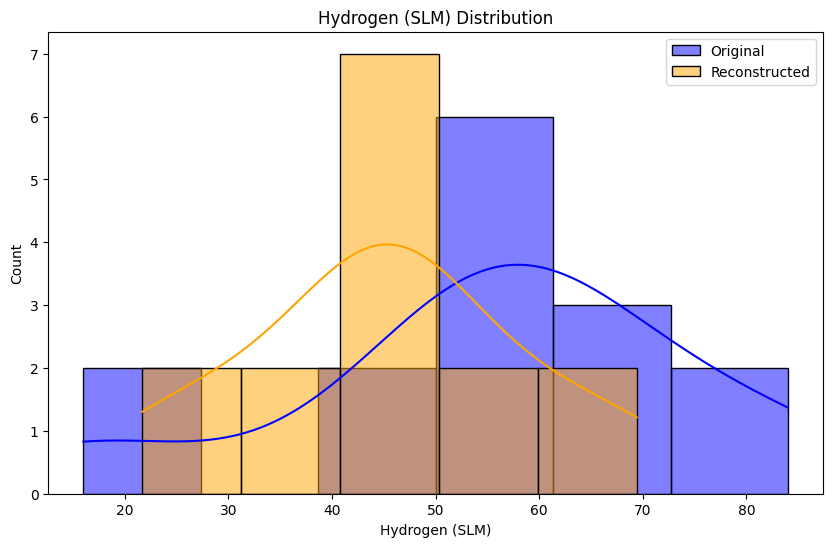

In [80]:
import matplotlib.pyplot as plt 
import seaborn as sns
# Function to reconstruct data
def reconstruct_data(gpp_cvae, test_dataloader):
    original_data = []
    reconstructed_data = []
    gpp_cvae.eval()
    with torch.no_grad():
        for batch_features, batch_conditions in test_dataloader:
            recon_batch, _, _, _ = gpp_cvae(batch_features, batch_conditions)
            original_data.append(batch_features)
            reconstructed_data.append(recon_batch)
    original_data = torch.cat(original_data, dim=0).cpu().numpy()
    reconstructed_data = torch.cat(reconstructed_data, dim=0).cpu().numpy()
    original_data = scaler_features.inverse_transform(original_data)
    reconstructed_data = scaler_features.inverse_transform(reconstructed_data)
    return original_data, reconstructed_data

# Reconstruct data
original_data, reconstructed_data = reconstruct_data(gpp_cvae, test_dataloader)

# Plotting function for individual gas variables
def plot_distribution(original, reconstructed, feature_name):
    plt.figure(figsize=(10, 6))
    sns.histplot(original, kde=True, color='blue', alpha=0.5, label='Original')
    sns.histplot(reconstructed, kde=True, color='orange', alpha=0.5, label='Reconstructed')
    plt.title(f'{feature_name} Distribution')
    plt.xlabel(feature_name)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Plot distributions for Argon (Ar_un), Nitrogen (N2_un), and Hydrogen (H2_un)
plot_distribution(original_data[:, 0], reconstructed_data[:, 0], 'Argon (SLM)')
plot_distribution(original_data[:, 1], reconstructed_data[:, 1], 'Nitrogen (SLM)')
plot_distribution(original_data[:, 2], reconstructed_data[:, 2], 'Hydrogen (SLM)')


In [81]:
    gpp_cvae.eval()  # Set model to evaluation mode
    test_loss = 0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch_features, batch_conditions in test_dataloader:
            # Forward pass
            recon_batch, mu, logvar, z = gpp_cvae(batch_features, batch_conditions)
            
            # Calculate loss (without backpropagation)
            loss = gpp_cvae.loss_function(recon_batch, batch_features, mu, logvar, z)
            
            # Accumulate test loss
            test_loss += loss.item()
    
    # Compute average test loss for the epoch
    average_test_loss = test_loss / len(test_dataloader.dataset)

In [82]:
average_test_loss

0.09865423838297525

In [83]:
features_train_unc= torch.tensor(features_train, dtype=torch.float32)
conditions_train_unc= torch.tensor(conditions_train, dtype=torch.float32)
import torch

# Ensure your model is in evaluation mode
gpp_cvae.eval()

# Get latent space representations for your entire dataset
with torch.no_grad():
    mu, logvar = gpp_cvae.encoder(features_train_tensor, conditions_train_tensor)
    z = gpp_cvae.reparameterize(mu, logvar)

# Calculate uncertainty using the Gaussian Process model
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = gpp_cvae.gp_model(z)
    mean = predictions.mean
    variance = predictions.variance
    std_dev = variance.sqrt()

# Convert to numpy for easier handling
z = z.cpu().numpy()
mean = mean.cpu().numpy()
std_dev = std_dev.cpu().numpy()

In [84]:
mean

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [85]:
std_dev

array([0.0359977 , 0.03210844, 0.03306191, 0.05096637, 0.06200403,
       0.050497  , 0.03448092, 0.02489756, 0.04227864, 0.02015602,
       0.03672674, 0.04461699, 0.06944074, 0.05464661, 0.08928791,
       0.0423343 , 0.04571953, 0.07068788, 0.02754302, 0.02764832,
       0.2211588 , 0.07240632, 0.03273579, 0.02569805, 0.04531654,
       0.03111189, 0.05700383, 0.03209637, 0.64925337, 0.02618686,
       0.3380311 , 0.0241841 , 0.02689816, 0.06882644, 0.16009669,
       0.03190779, 0.03028869, 0.07628448, 0.0676415 , 0.12354118,
       0.03958543, 0.03344192, 0.05543632, 0.04581232, 0.04181509,
       0.0343289 , 0.05391281, 0.13865134, 0.04077989, 0.03590652,
       0.03372589, 0.05921832, 0.02578372, 0.5452086 , 0.03627851,
       0.16426192, 0.27207896, 0.0283629 , 0.09282466, 0.03416355,
       0.11859079, 0.02220472, 0.03811449, 0.01986036, 0.03437185,
       0.02687045, 0.04496398, 0.09189974, 0.02446284], dtype=float32)

In [86]:
unc['unc'].describe()

count    59.000000
mean      0.089805
std       0.112045
min       0.021985
25%       0.034494
50%       0.044768
75%       0.082574
max       0.568018
Name: unc, dtype: float64

In [87]:
pd.DataFrame(std_dev).describe()

,0
count,69.000000
mean,0.076358
std,0.107326
min,0.019860
25%,0.032096
50%,0.041815
75%,0.068826
max,0.649253


In [324]:
unc_water.head()

,Argon,Nitrogen,Hydrogen,0,1,2,3,unc
0,87.0000,129.0000,84.0000,100.0,3.34,2779.500,120.34,0.521710
3,59.3094,112.8094,59.4408,100.0,3.34,2796.225,120.34,0.187814
6,147.0000,129.0000,24.0000,100.0,3.34,2689.800,120.34,0.206776
7,58.0000,112.1503,58.9852,100.0,3.34,2791.747,120.34,0.221544
10,160.0000,70.0000,20.0000,100.0,3.34,2550.700,120.34,0.533835


In [ ]:
df_unnormalized_points

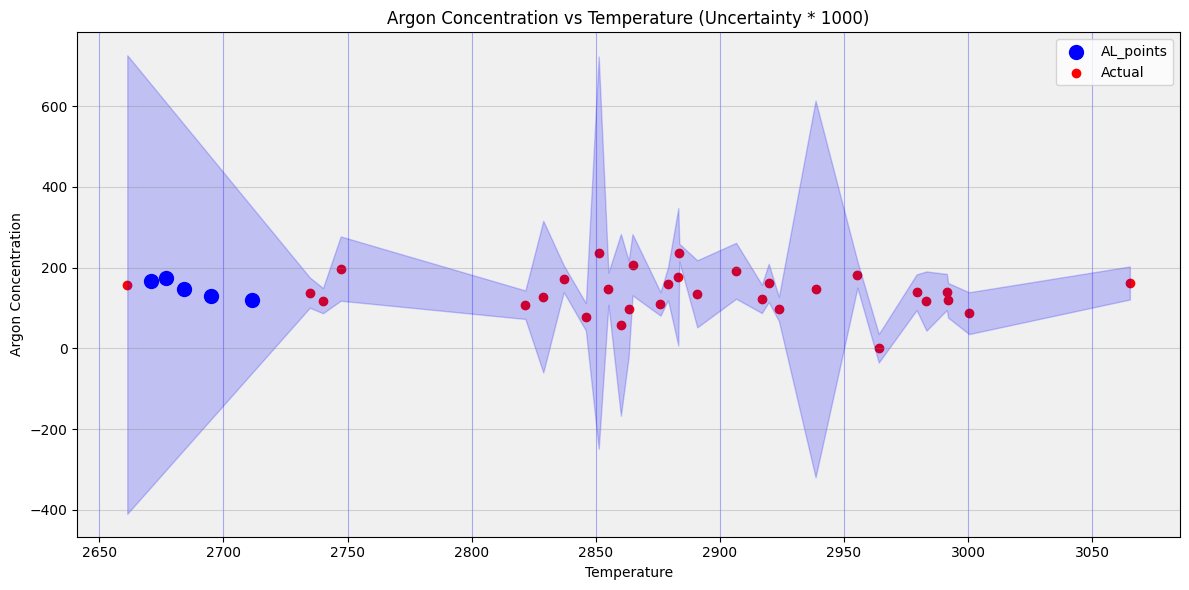

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Argon'], color='blue', s=100, marker='o', label='AL_points')

# Plot the main Argon concentration
plt.scatter(df['Mean Particle Temperature (°C)'], df['Argon'], color='red',label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Argon'] - df['unc'] * uncertainty_factor, 
                 df['Argon'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Argon'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Velocity')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Argon Concentration')
plt.title(f'Argon Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

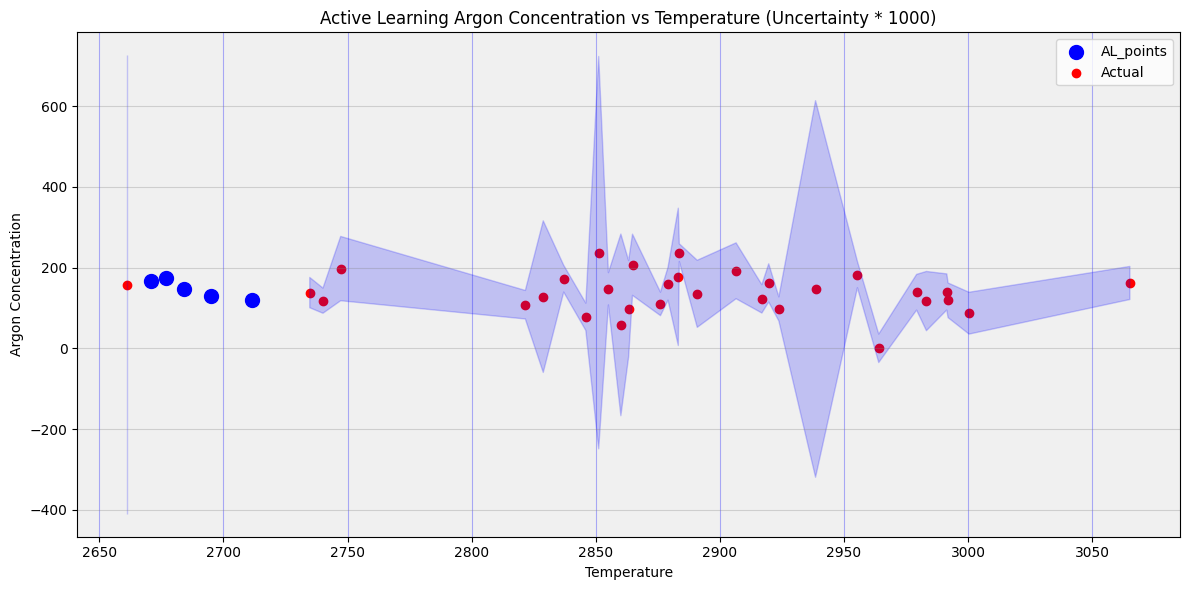

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Argon'], color='blue', s=100, marker='o', label='AL_points')

# Plot the main Argon concentration
plt.scatter(unc_eth['Mean Particle Temperature (°C)'], unc_eth['Argon'], color='red', label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Argon'] - df['unc'] * uncertainty_factor, 
                 df['Argon'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Argon'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Velocity')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Argon Concentration')
plt.title(f'Active Learning Argon Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

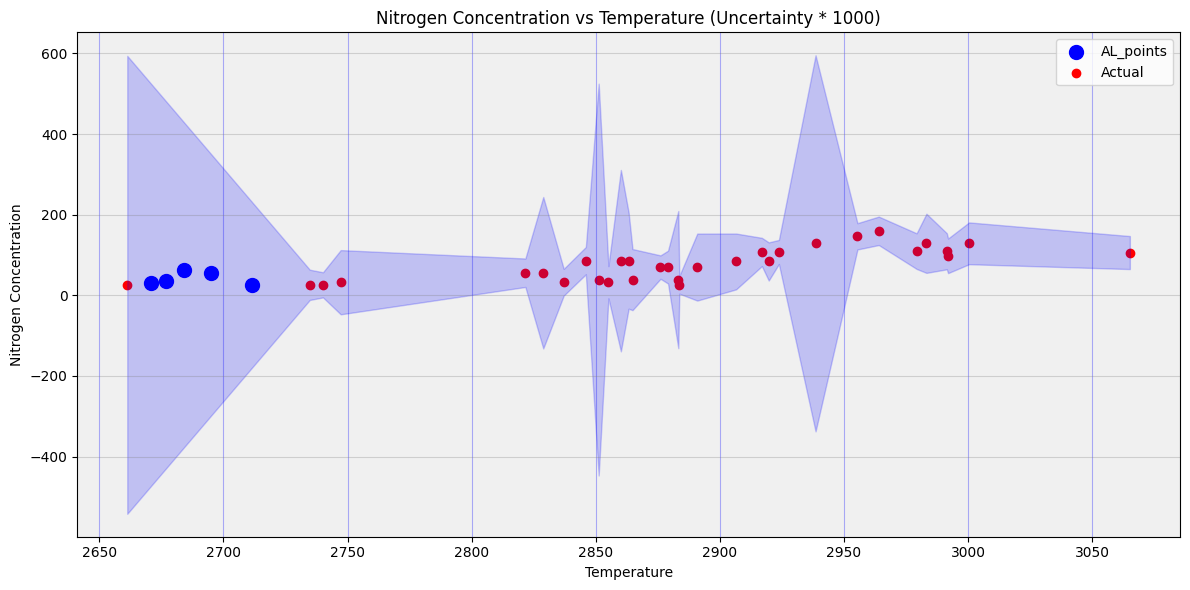

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Nitrogen'], color='blue', s=100, marker='o', label='AL_points')

# Plot the main Argon concentration
plt.scatter(df['Mean Particle Temperature (°C)'], df['Nitrogen'], color='red', label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Nitrogen'] - df['unc'] * uncertainty_factor, 
                 df['Nitrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Nitrogen')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Nitrogen Concentration')
plt.title(f'Nitrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

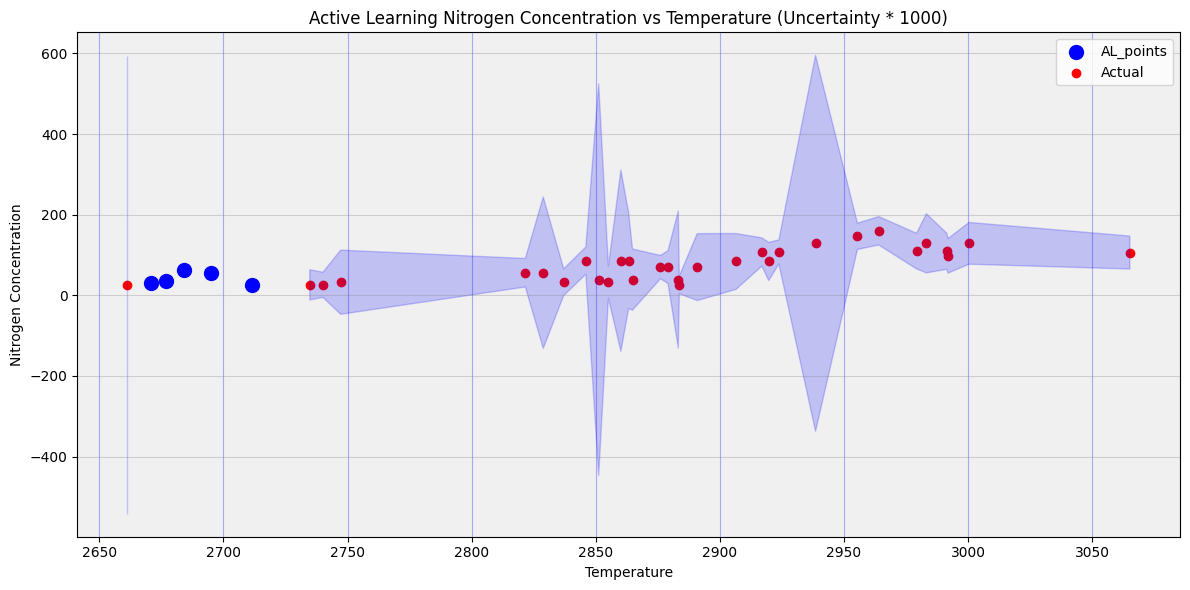

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Nitrogen'], color='blue', s=100, marker='o',label='AL_points')

# Plot the main Argon concentration
plt.scatter(unc_eth['Mean Particle Temperature (°C)'], unc_eth['Nitrogen'], color='red',label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Nitrogen'] - df['unc'] * uncertainty_factor, 
                 df['Nitrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Nitrogen')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Nitrogen Concentration')
plt.title(f'Active Learning Nitrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

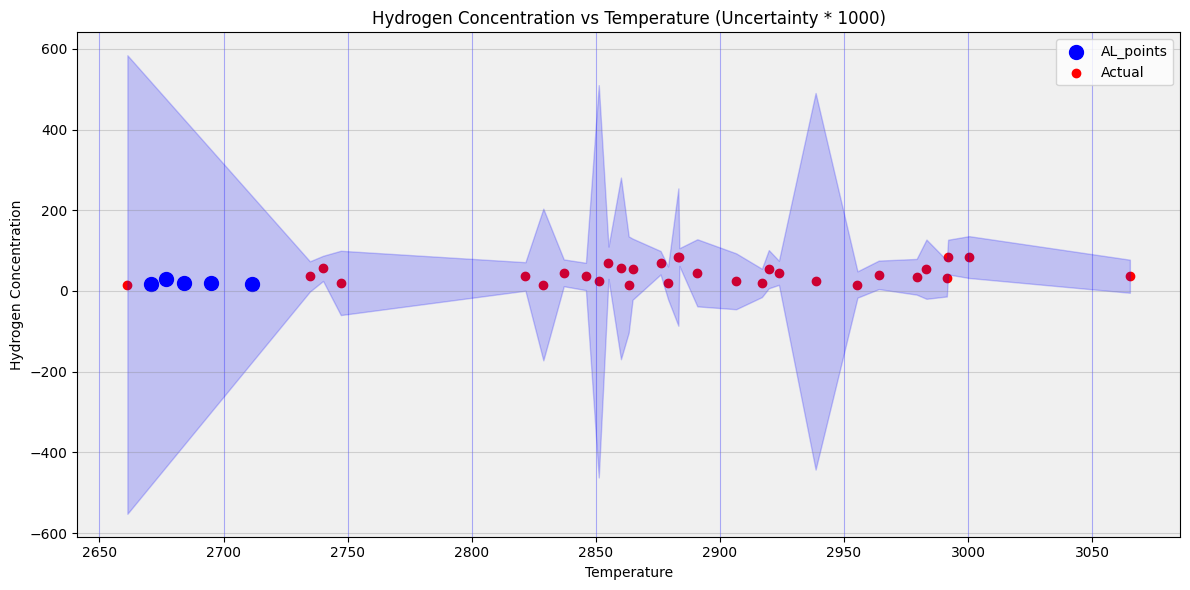

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Hydrogen'], color='blue', s=100, marker='o', label='AL_points')

# Plot the main Argon concentration
plt.scatter(df['Mean Particle Temperature (°C)'], df['Hydrogen'], color='red', label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Hydrogen'] - df['unc'] * uncertainty_factor, 
                 df['Hydrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Hydrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Hydrogen')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Hydrogen Concentration')
plt.title(f'Hydrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

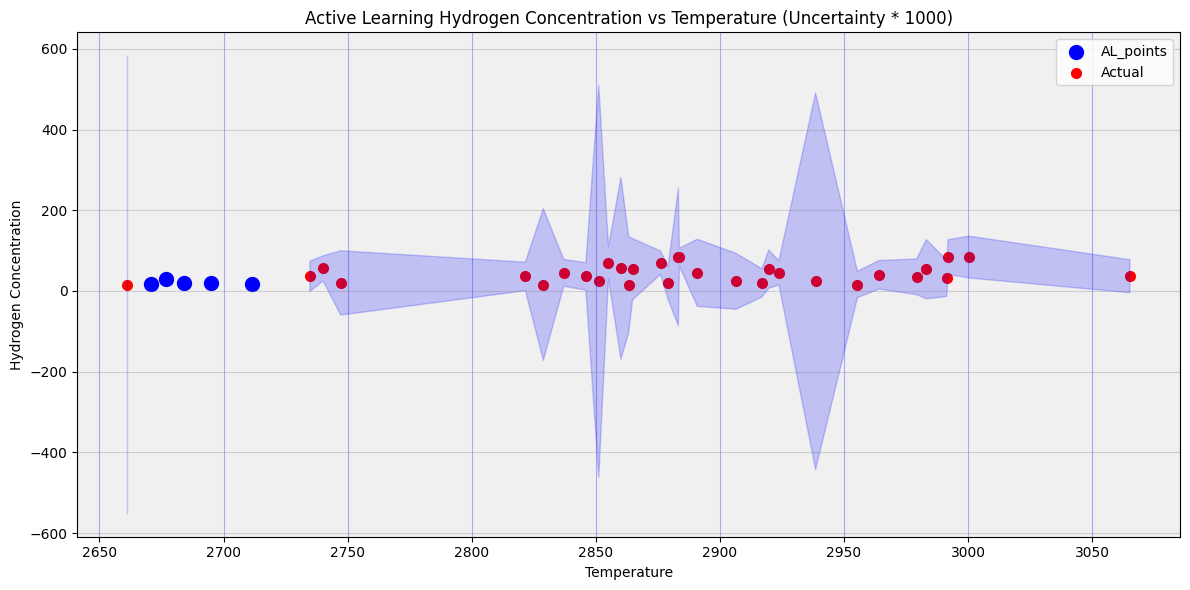

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_eth_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_unnormalized_points = df_unnormalized_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_unnormalized_points['Mean Particle Temperature (°C)'], df_unnormalized_points['Hydrogen'], color='blue', s=100, marker='o', label = 'AL_points')

# Plot the main Argon concentration
plt.scatter(unc_eth['Mean Particle Temperature (°C)'], unc_eth['Hydrogen'], color='red', linewidth=2, label='Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Hydrogen'] - df['unc'] * uncertainty_factor, 
                 df['Hydrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Hydrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Hydrogen')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Hydrogen Concentration')
plt.title(f'Active Learning Hydrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [166]:
df_new_top_points

,Argon,Nitrogen,Hydrogen,Mean Particle Temperature (°C)
3,184.981143,74.446181,33.088533,2677.018728
4,229.406088,97.772344,22.317716,2696.688179
2,162.956690,30.037374,23.838709,2724.604021
1,156.844589,37.519565,23.928517,2731.723956
0,145.775665,30.130181,18.819752,2753.182730


In [176]:
df_new_top_points

,Argon,Nitrogen,Hydrogen,Mean Particle Temperature (°C)
3,184.981143,74.446181,33.088533,2677.018728
4,229.406088,97.772344,22.317716,2696.688179
2,162.956690,30.037374,23.838709,2724.604021
1,156.844589,37.519565,23.928517,2731.723956
0,145.775665,30.130181,18.819752,2753.182730


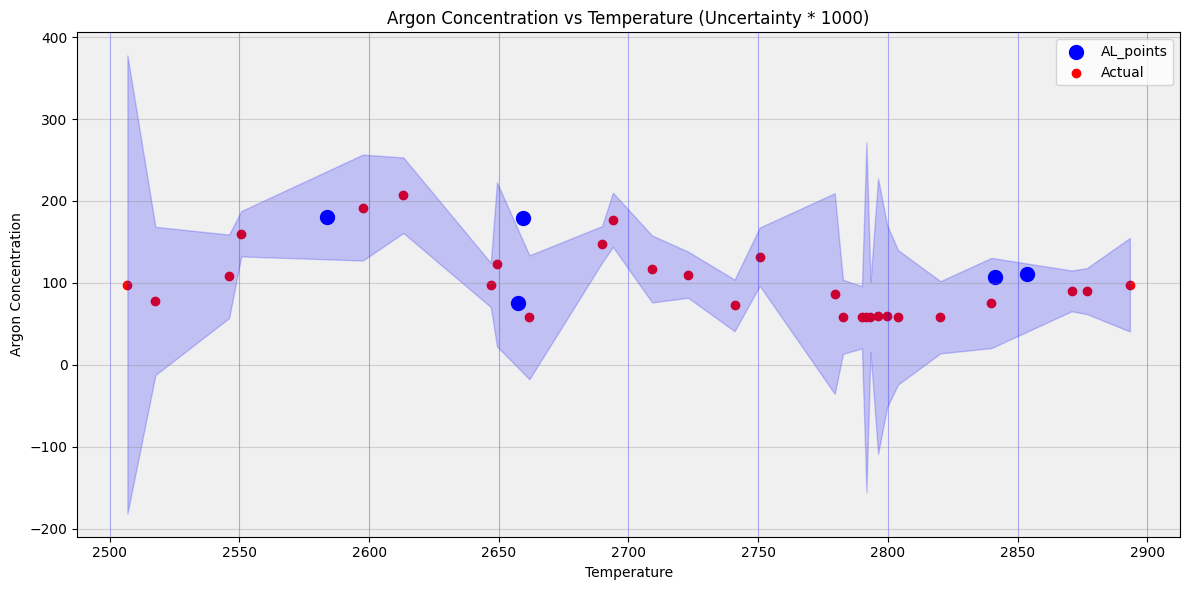

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Argon'], color='blue', s=100, marker='o', label = 'AL_points')

# Plot the main Argon concentration
#plt.plot(df['Mean Particle Temperature (°C)'], df['Argon'], color='blue', linewidth=2, label='Argon')
plt.scatter(df['Mean Particle Temperature (°C)'], df['Argon'], color='red', label = 'Actual')
# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Argon'] - df['unc'] * uncertainty_factor, 
                 df['Argon'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Argon'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Argon Concentration')
plt.title(f'Argon Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

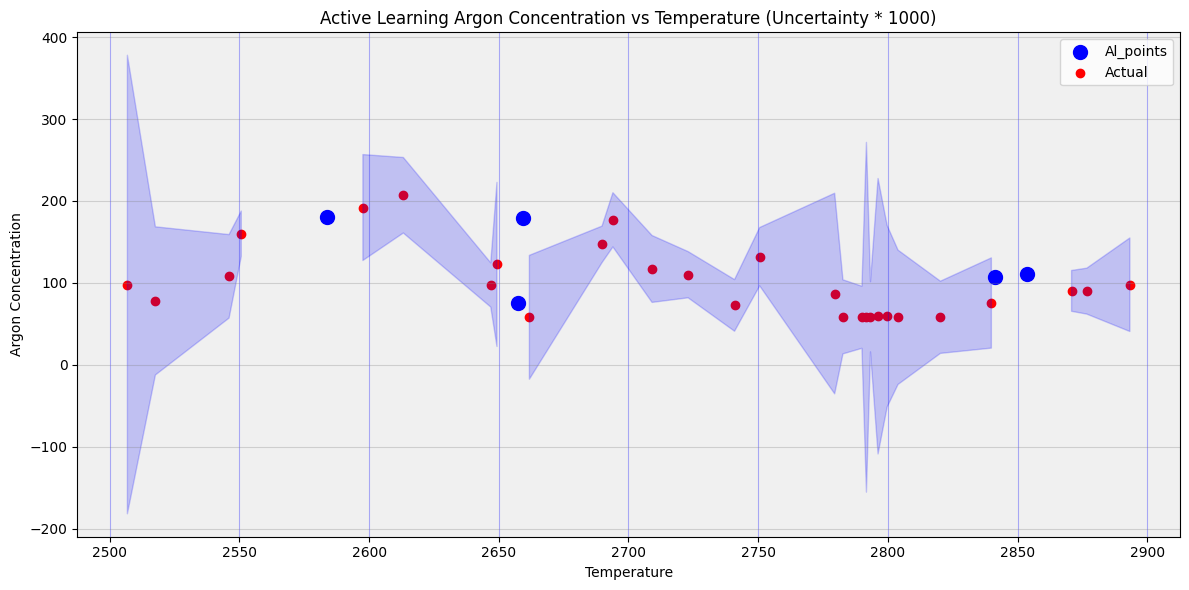

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Argon'], color='blue', s=100, marker='o', label = 'Al_points')
#plt.scatter(df['Mean Particle Temperature (°C)'], df['Argon'], color='red', s=50, marker='o')
# Plot the main Argon concentration
plt.scatter(unc_water['Mean Particle Temperature (°C)'], unc_water['Argon'], color='red', label = 'Actual')

# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Argon'] - df['unc'] * uncertainty_factor, 
                 df['Argon'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Argon'].mean()
#plt.axhline(y=optimal_velocity, color='purple', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Argon Concentration')
plt.title(f'Active Learning Argon Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

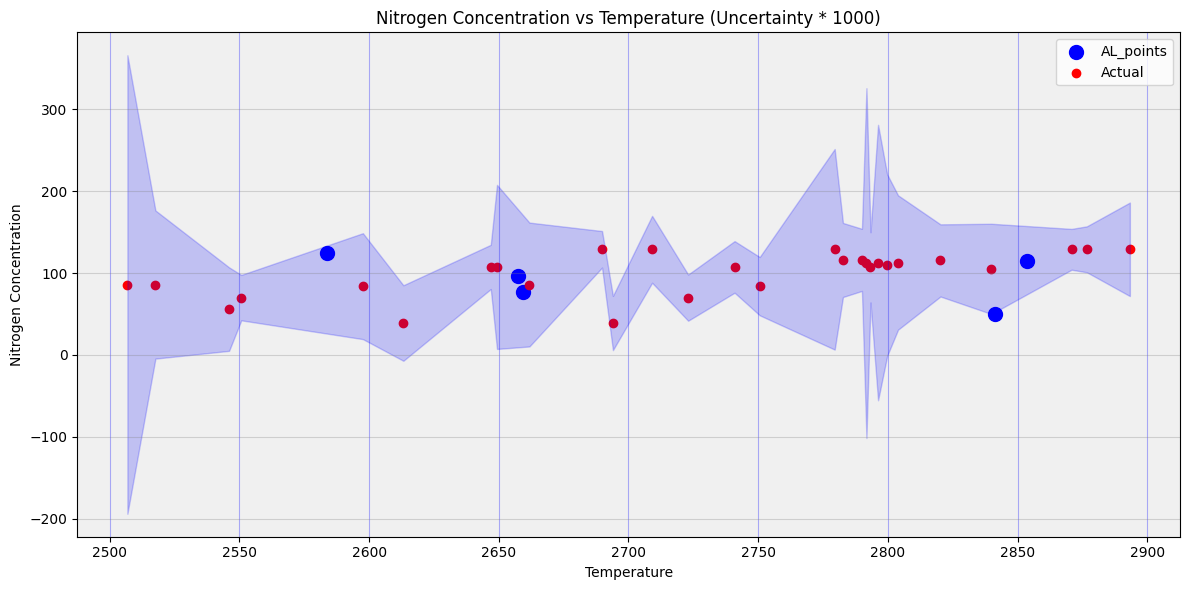

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Nitrogen'], color='blue', s=100, marker='o', label = 'AL_points')

# Plot the main Argon concentration
#plt.plot(df['Mean Particle Temperature (°C)'], df['Argon'], color='blue', linewidth=2, label='Argon')
plt.scatter(df['Mean Particle Temperature (°C)'], df['Nitrogen'], color='red', label = 'Actual')
# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Nitrogen'] - df['unc'] * uncertainty_factor, 
                 df['Nitrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Nitrogen Concentration')
plt.title(f'Nitrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

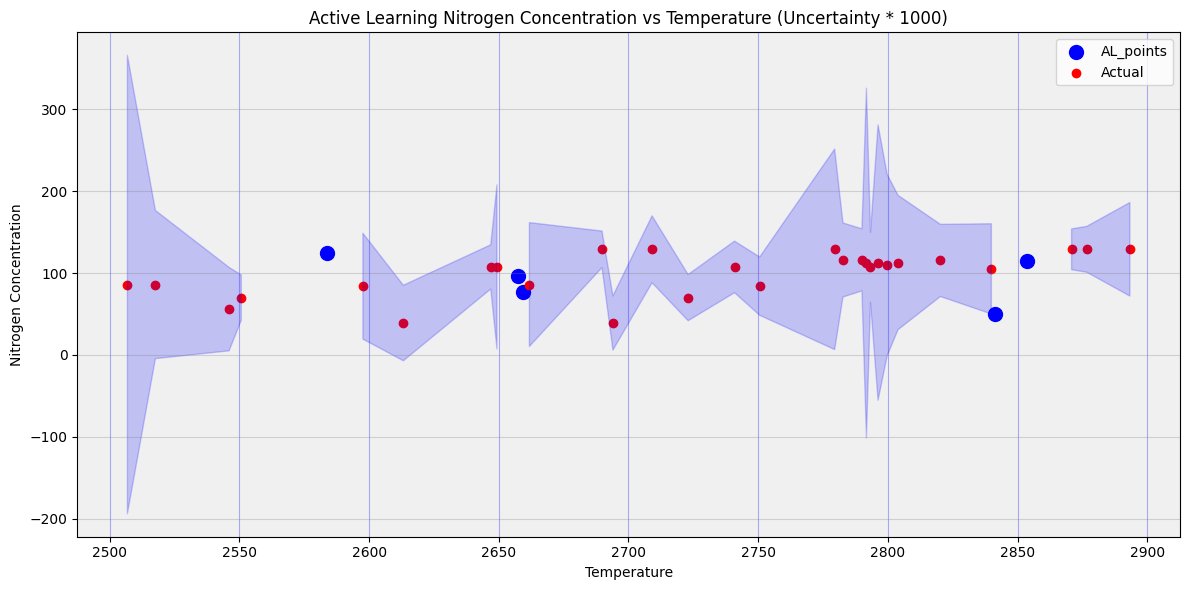

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Nitrogen'], color='blue', s=100, marker='o',label = 'AL_points')

# Plot the main Argon concentration
#plt.plot(df['Mean Particle Temperature (°C)'], df['Argon'], color='blue', linewidth=2, label='Argon')
plt.scatter(unc_water['Mean Particle Temperature (°C)'], unc_water['Nitrogen'], color='red',label = 'Actual')
# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Nitrogen'] - df['unc'] * uncertainty_factor, 
                 df['Nitrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Nitrogen Concentration')
plt.title(f'Active Learning Nitrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

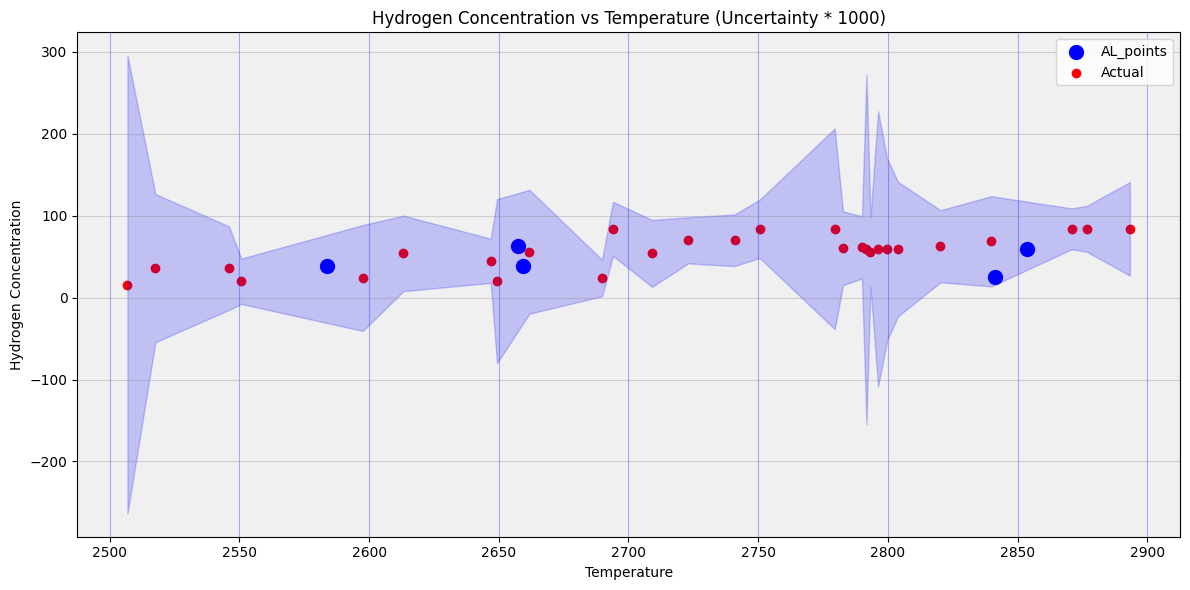

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Hydrogen'], color='blue', s=100, marker='o',label = 'AL_points')

# Plot the main Argon concentration
#plt.plot(df['Mean Particle Temperature (°C)'], df['Argon'], color='blue', linewidth=2, label='Argon')
plt.scatter(df['Mean Particle Temperature (°C)'], df['Hydrogen'], color='red',label = 'Actual')
# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Hydrogen'] - df['unc'] * uncertainty_factor, 
                 df['Hydrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Hydrogen Concentration')
plt.title(f'Hydrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

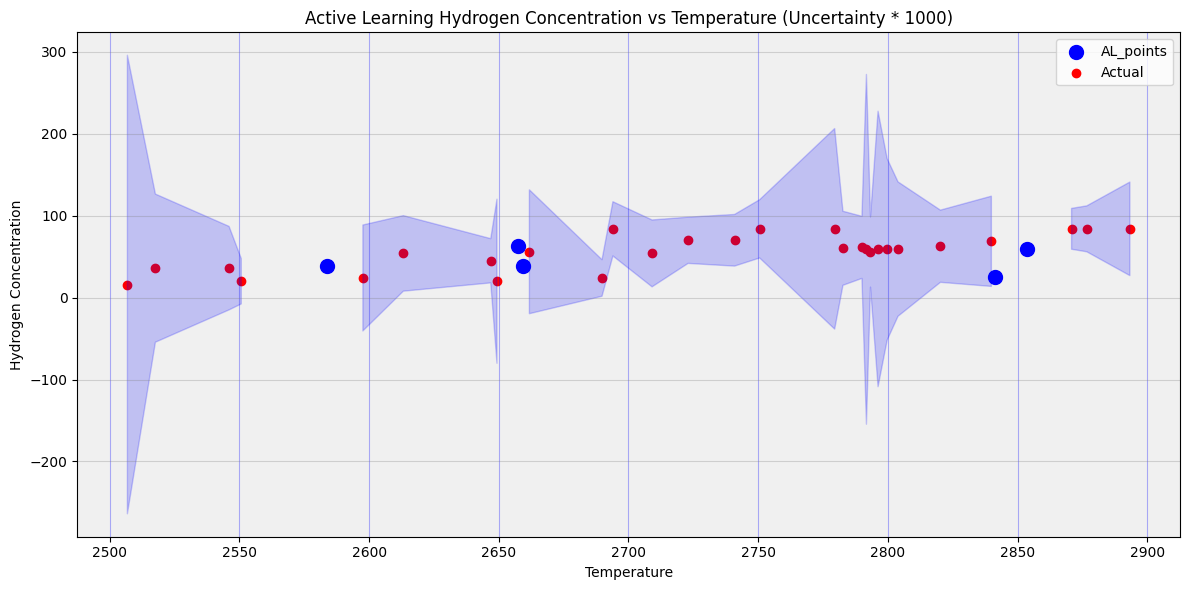

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = unc_water_al

# Sort the dataframe by temperature
df = df.sort_values('Mean Particle Temperature (°C)')
df_new_top_points = df_new_top_points.sort_values('Mean Particle Temperature (°C)')

# Amplification factor for uncertainty (adjust as needed)
uncertainty_factor = 1000

# Create the plot
plt.figure(figsize=(12, 6))

plt.scatter(df_new_top_points['Mean Particle Temperature (°C)'], df_new_top_points['Hydrogen'], color='blue', s=100, marker='o',label = 'AL_points')

# Plot the main Argon concentration
#plt.plot(df['Mean Particle Temperature (°C)'], df['Argon'], color='blue', linewidth=2, label='Argon')
plt.scatter(unc_water['Mean Particle Temperature (°C)'], unc_water['Hydrogen'], color='red',label = 'Actual')
# Plot the amplified uncertainty band
plt.fill_between(df['Mean Particle Temperature (°C)'], 
                 df['Hydrogen'] - df['unc'] * uncertainty_factor, 
                 df['Hydrogen'] + df['unc'] * uncertainty_factor, 
                 color='blue', alpha=0.2)

# Plot the "Optimal Velocity" line (using mean Argon concentration as an example)
#optimal_velocity = df['Nitrogen'].mean()
#plt.axhline(y=optimal_velocity, color='red', linestyle='--', label='Optimal Argon')

# Set labels and title
plt.xlabel('Temperature')
plt.ylabel('Hydrogen Concentration')
plt.title(f'Active Learning Hydrogen Concentration vs Temperature (Uncertainty * {uncertainty_factor})')

# Customize the grid
plt.grid(True, axis='x', color='blue', alpha=0.3)
plt.grid(True, axis='y', color='gray', alpha=0.3)

# Set the background color
plt.gca().set_facecolor('#f0f0f0')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [110]:
temp2 = 2858.84
Cp = (1 - x) * find_closest_cp(temp2, cp_zro2) + x * find_closest_cp(temp2, cp_y2o3)
Cp

120.34

In [368]:
conditions_train

array([[1.00000000e+02, 3.34000000e+00, 2.77950000e+03, 1.20340000e+02,
        5.77100000e+02, 1.38000000e+01],
       [7.83700000e+01, 4.50000000e-01, 2.90652763e+03, 1.20340000e+02,
        6.69686102e+02, 1.08000000e+01],
       [7.83700000e+01, 4.50000000e-01, 2.83709000e+03, 1.20340000e+02,
        4.98183103e+02, 1.00000000e+01],
       [1.00000000e+02, 3.34000000e+00, 2.79622500e+03, 1.20340000e+02,
        4.85284400e+02, 1.43000000e+01],
       [7.83700000e+01, 4.50000000e-01, 2.82884593e+03, 1.20340000e+02,
        4.07694068e+02, 1.11000000e+01],
       [7.83700000e+01, 4.50000000e-01, 3.06515110e+03, 1.37160000e+02,
        6.99782000e+02, 1.15000000e+01],
       [1.00000000e+02, 3.34000000e+00, 2.68980000e+03, 1.20340000e+02,
        5.93600000e+02, 1.21000000e+01],
       [1.00000000e+02, 3.34000000e+00, 2.79174700e+03, 1.20340000e+02,
        4.75876900e+02, 1.42000000e+01],
       [7.83700000e+01, 4.50000000e-01, 2.74011627e+03, 1.20340000e+02,
        3.26720000e+02, 

In [29]:
def generate_data_from_unexplored_latent_points(gpp_cvae, num_samples, conditions, existing_data, scaler_features, scaler_conditions):
    latent_points = torch.randn(num_samples, gpp_cvae.encoder.fc_mu.out_features)
    gpp_cvae.eval()
    with torch.no_grad():
        conditions_scaled = scaler_conditions.transform(conditions)
        conditions_tensor = torch.tensor(conditions_scaled, dtype=torch.float32).repeat(latent_points.size(0), 1)
        generated_data = gpp_cvae.decoder(latent_points, conditions_tensor)
        generated_data = scaler_features.inverse_transform(generated_data.numpy())
        generated_data = np.round(generated_data, decimals=2)  # Round the values to 2 decimal places
    
    # Ensure generated data does not match existing data
    unique_generated_data = []
    for data_point in generated_data:
        if not any(np.allclose(data_point, existing_row, atol=0.1) for existing_row in existing_data):
            unique_generated_data.append(data_point)
    
    return np.array(unique_generated_data)

# Existing data (original dataset)
existing_data = scaler_features.inverse_transform(features_train_scaled)

# Example conditions to use for generating data
example_conditions = [[78.37, 0.45, 3000, Cp, 400, 6]]    # Replace with actual values as needed

# Generate new unexplored data points
generated_unexplored_data = generate_data_from_unexplored_latent_points(
    gpp_cvae,
    num_samples=10,
    conditions=example_conditions,
    existing_data=existing_data,
    scaler_features=scaler_features,
    scaler_conditions=scaler_conditions
)
print("Generated Unexplored Data:", generated_unexplored_data)


Generated Unexplored Data: [[142.37  68.82  41.73]
 [146.22  63.27  37.85]
 [137.29  70.11  38.25]
 [135.57  72.72  35.63]
 [162.09  58.05  39.34]
 [137.61  79.86  36.36]
 [150.68  64.41  39.51]
 [138.95  67.09  38.01]
 [140.63  69.2   39.43]
 [157.85  59.24  38.08]]


In [30]:
def apply_constraints(new_data):
    valid_data = []
    for data_point in new_data:
        Ar_un, N2_un, H2_un = data_point
        Total_flow = Ar_un + N2_un + H2_un
        frac_N2 = N2_un / Total_flow
        frac_H2 = H2_un / Total_flow

        if Total_flow >= 130 and Total_flow <= 350 and frac_N2 <= 0.8 and frac_H2 <= 0.28:
            valid_data.append(data_point)

    return np.array(valid_data)

# Apply constraints to the generated data
constrained_unexplored_data = apply_constraints(generated_unexplored_data)
print("Unexplored Data:", generated_unexplored_data)

Unexplored Data: [[142.37  68.82  41.73]
 [146.22  63.27  37.85]
 [137.29  70.11  38.25]
 [135.57  72.72  35.63]
 [162.09  58.05  39.34]
 [137.61  79.86  36.36]
 [150.68  64.41  39.51]
 [138.95  67.09  38.01]
 [140.63  69.2   39.43]
 [157.85  59.24  38.08]]
